# Segment and Prediction Notebook

## Setup

### Imports and Global Variables


In [170]:
import os
import random
import threading

from queue import Queue

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np 

from PIL import Image
from ultralytics import YOLO

obj_name = {
    0: 'Main Pad',
    1: 'LED Pad',
    2: 'Main Chip',
    3: 'LED Chip'
}

# models = {
#     'final_yolov8s-seg_cgi_sled': ['segment', '320'],
#     'final_yolov8s-seg_human_sled': ['segment', '320'],
#     'final_yolov8s-seg_combined_sled': ['segment', '320'],
#     'final_yolov9c-seg_cgi_sled': ['segment', '320'],
#     'final_yolov9c-seg_human_sled': ['segment', '320'],
#     'final_yolov9c-seg_combined_sled': ['segment', '320'],
#     'final_yolov8s-obb_cgi_sled': ['OBB', '400'],
#     'final_yolov8s-obb_human_sled': ['OBB', '400'],
#     'final_yolov8s-obb_combined_sled': ['OBB', '400'],
# }

models = {
    'r_test_yolov8s-seg_control': ['segment', '320'],
    'r_test_yolov8s-seg_nocomp': ['segment', '320'],
    'r_test_yolov8s-seg_somecomp': ['segment', '320'],
}

l_metrics = [None] * len(models)
q = Queue(maxsize=1)

test_cropped_path = os.path.relpath("./datasets/test_cropped")
test_path = os.path.relpath("./datasets/test")

test_cropped_yaml_path = os.path.relpath("./datasets_yaml/test_cropped.yaml")
test_yaml_path = os.path.relpath("./datasets_yaml/sled/combined_sled.yaml")

images = []
no_led = []

log_level = 0


### Thread safe function to test and validate models


In [171]:
def thread_safe_test(model_name, type, i, cropped_test, modified_imgsz):

    q.put(1)

    model = YOLO(os.path.join("runs", type, model_name, "weights", "best.pt"))

    if cropped_test:
        name = 'ctest_' + model_name
        if os.path.exists(os.path.join("runs", type, name)):
            return
        l_metrics[i] = model.val(data=test_cropped_yaml_path, plots=True, device=0, imgsz=modified_imgsz, split='test', name=name, task=type, save_json=True)
    else:
        name = 'test_' + model_name
        if os.path.exists(os.path.join("runs", type, name)):
            return
        l_metrics[i] = model.val(data=test_yaml_path, plots=True, device=0, split='test', name=name, task=type, save_json=True)



### Function to get a list of all images


In [172]:
def get_images(path, amount=-1):
    img_list = []
    for file in os.listdir(path):
        if file.endswith(".jpg") or file.endswith(".png"):
            img_list.append(os.path.join(path, file))
    random.shuffle(img_list)
    return img_list if amount == -1 else img_list[:amount]


### Function to dissect and label images


In [173]:
def plot_data(results, color: dict, 
             label_lvl = 1,
             led_only = True,  
             predict = False, 
             plot_seg = True, 
             show_img = False, 
             output_type = None):

    SORT_ORDER = {1: 0, 0: 1, 3: 2, 2: 3}
    SHOW_CLS = [1, 3] if led_only else [0, 1, 2, 3]
    CHIP_CLS = [2, 3]

    if isinstance(output_type, list):
        if len(output_type) != len(results):
            raise ValueError("Length of output_type must match the number of results")
    
    if not isinstance(color, dict):
        raise ValueError("Color must be a dictionary, including all 4 classes")
    
    if color.keys() != {0, 1, 2, 3}:
        raise ValueError("Color dictionary must include all 4 classes: 0, 1, 2, 3")

    mpl.rcParams['figure.dpi'] = 300


    for i, result in enumerate(results):
        fig, ax = plt.subplots()

        img = cv2.cvtColor(cv2.imread(result.path), cv2.COLOR_BGR2RGB)
        m = None

        main_pad_bounds = None
        led_pad_bounds = None

        masks = [x.xy[0] for x in result.masks]
        classes = [int(x) for x in result.boxes.cls.tolist()]
        confs = result.boxes.conf

        obj_tups = zip(classes, masks, confs)
        obj_tups = list(sorted(obj_tups, key=lambda x: SORT_ORDER[x[0]]))

        if obj_tups[0][0] == 1:
            rect = cv2.minAreaRect(np.array(obj_tups[0][1]))
            if rect[1][0] > rect[1][1] and (90 * round(rect[2]/90)) == 0:
                angle = rect[2]
            elif rect[1][0] < rect[1][1] and (90 * round(rect[2]/90)) == 90:
                angle = 270 + rect[2]
            elif rect[1][0] > rect[1][1] and (90 * round(rect[2]/90)) == 90:
                angle = rect[2]
            else:
                angle = 270 + rect[2]
            m = cv2.getRotationMatrix2D(rect[0], angle, 1)

        if m is not None:
            img = cv2.warpAffine(img, m, (img.shape[1], img.shape[0]))


        for cls, msk, conf in obj_tups:
            if cls not in SHOW_CLS:
                break

            if m is not None:
                msk = cv2.transform(np.array([msk]), m)[0]

            rect = cv2.minAreaRect(np.array(msk))
            obb = cv2.boxPoints(rect)

            seg_color = color[cls]['seg']
            box_color = color[cls]['box']
            pred_color = color[cls]['pred'] if 'pred' in color[cls] else None
            text_color = color[cls]['text']

            if predict and cls in CHIP_CLS:
                obb_alpha = 0.5 * box_color[1]
                seg_alpha = 0.5 * seg_color[1]
                text_color = "none"
            else:
                obb_alpha = box_color[1]
                seg_alpha = seg_color[1]


            (cx, cy), (width, height), angle = rect
            if (90 * round(rect[2]/90)) == 90:
                height, width = width, height
            if cls == 0:
                main_pad_bounds = cv2.RotatedRect((cx,cy), (width * 0.85, height * 0.85), 0)
            elif cls == 1:
                led_pad_bounds = cv2.RotatedRect((cx,cy), (width * 0.875, height * 0.8), 0)

            obb_poly = patches.Polygon(obb, linewidth=2, edgecolor=box_color[0], facecolor='none', alpha=obb_alpha)
            ax.add_patch(obb_poly)

            label = ""
            if label_lvl > 0:
                label = f"Segmented {obj_name[cls]}"
            if label_lvl > 2:
                label = f"{label}\nConf.: {conf:.4f}"
            
            if cls in CHIP_CLS:
                if label_lvl > 1:
                    status = 'Pass' if abs(angle-90) < 2 or abs(angle-90) > 88 else 'Fail'
                    label = f"{label}\nAngle: {abs(angle-90):.3f} - {status}"

                    pad_bounds = main_pad_bounds if cls == 2 else led_pad_bounds 
                    x, y, w, h = cv2.boundingRect(np.array(msk))               

                    max_x = x + w
                    min_x = x
                    max_y = y + h
                    min_y = y

                    pad_max_x = pad_bounds.center[0] + pad_bounds.size[0]/2
                    pad_min_x = pad_bounds.center[0] - pad_bounds.size[0]/2
                    pad_max_y = pad_bounds.center[1] + pad_bounds.size[1]/2
                    pad_min_y = pad_bounds.center[1] - pad_bounds.size[1]/2

                    if max_x < pad_max_x and min_x > pad_min_x and max_y < pad_max_y and min_y > pad_min_y:
                        label = f"{label}\nWithin Bounds"
                    else:
                        label = f"{label}\nOut of Bounds"
                    
            if cls not in CHIP_CLS or not predict:
                ax.text(cx-width/2+2, cy+height/2+6, label, color=text_color, verticalalignment='top', fontsize=2.5)

            for point in msk if plot_seg else []:
                plt.scatter(point[0], point[1], c=seg_color[0], s=0.5, alpha=seg_alpha)

            if predict:
                if cls == 1:
                    chip_1 = cv2.RotatedRect((cx-0.22*width,cy), (width*0.35, height*0.7), 0)
                    chip_2 = cv2.RotatedRect((cx+0.22*width,cy), (width*0.33, height*0.66), 0)

                    chip_1 = cv2.boxPoints(chip_1)
                    chip_2 = cv2.boxPoints(chip_2)

                    chip_1_poly = patches.Polygon(chip_1, linewidth=2, edgecolor=pred_color[0], facecolor='none', alpha=pred_color[1])
                    chip_2_poly = patches.Polygon(chip_2, linewidth=2, edgecolor=pred_color[0], facecolor='none', alpha=pred_color[1])

                    ax.add_patch(chip_1_poly)
                    ax.add_patch(chip_2_poly)

                elif cls == 0:
                    main_chip = cv2.RotatedRect((cx, cy), (width*0.7, height*0.7), 0)
                    main_chip = cv2.boxPoints(main_chip)

                    main_chip_poly = patches.Polygon(main_chip, linewidth=2, edgecolor=pred_color[0], facecolor='none', alpha=pred_color[1])

                    ax.add_patch(main_chip_poly)

        if show_img:
            plt.imshow(img)
        else:
            ax.invert_yaxis()
        
        plt.axis('off')
        plt.style.use('dark_background')
        ax.autoscale_view()
        ax.set_aspect('equal')

        if output_type:
            if isinstance(output_type, list):
                name = output_type[i]
            elif output_type == 'index':
                name = i
            elif output_type == 'name':
                name = os.path.basename(result.path)
            else:
                name = f'{output_type}_{i}'
            
            name = f'{name}{"_predict" if predict else ""}{"_contour" if plot_seg else ""}.png'

            if not os.path.exists('./results'):
                os.makedirs('./results')
            plt.savefig(f'./results/{name}', bbox_inches='tight', pad_inches=0, transparent=True)



### Other utils


In [174]:
def log(message, level = 1):
    if log_level >= level:
        print(message)


## Run Codes


### Validating the models


In [ ]:
for i, (model, v) in enumerate(models.items()):
    t = threading.Thread(target=thread_safe_test, args=(model, v[0], i, False, v[1]))
    t.start()
    t.join()
    q.get()


In [ ]:
for i, metric in enumerate(l_metrics):
    print(metric.box.map)


### Label checking


In [ ]:
# img_dir = 'datasets/rendered/train'
# img_name = 'bad_9.png'

# img_dir = 'datasets/test_cropped'
# img_name = 'HHF22220109_5_20_72-MW_1.jpg'

img_dir = 'datasets/render_tests/control/train'
img_name = 'control_10800.png'

# Load the image
image_path = os.path.join(img_dir, img_name)
image = Image.open(image_path)

image_width, image_height = image.size

# Load the label in YOLO polygon format
label_name = img_name.replace('png', 'txt').replace('jpg', 'txt')
label_path = os.path.join(img_dir, label_name)
with open(label_path, 'r') as f:
    labels = f.read().splitlines()

# Parse the label to extract the polygon coordinates
# Assuming the label is in the format: id x1 y1 x2 y2 x3 y3 x4 y4
shapes = []
for label in labels:
    label = label.split(' ')
    label = [ float(x) for x in label ]
    point1 = (label[1]*image_width, label[2]*image_height)
    point2 = (label[3]*image_width, label[4]*image_height)
    point3 = (label[5]*image_width, label[6]*image_height)
    point4 = (label[7]*image_width, label[8]*image_height)

    shapes.append((label[0],[point1, point2, point3, point4]))


# Plot the image
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')

for data in shapes:
    i, shape = data
    polygon = patches.Polygon(shape, linewidth=1, edgecolor='r', facecolor='none')    

    # Add the patch to the Axes
    ax.add_patch(polygon)

    # Add label to the patches according to obj_name
    label = obj_name[i]
    ax.text(shape[0][0], shape[0][1], label, color='white')

plt.show()


### Display outputs


In [175]:
model = YOLO('runs/segment/final_yolov9c-seg_combined_sled/weights/best.pt')

# images = get_images(test_path, 5)

images =  [
    "C:/Users/KohCo/Desktop/FYP/ASPLProject/datasets/test/HHH23630057_9_13_55-DPI_1.jpg",
    "C:/Users/KohCo/Desktop/FYP/ASPLProject/datasets/test/HHH23630078_40_11_55-DPI_1.jpg",
    "C:/Users/KohCo/Desktop/FYP/ASPLProject/datasets/test/HHH23740006_4_9_55-DPI_1.jpg"
]

results = model(images)

# results = model(images, imgsz=320)



0: 640x384 1 Main Pad, 1 LED Pad, 1 Main Chip, 2 LED Chips, 15.3ms
1: 640x384 1 Main Pad, 1 LED Pad, 1 Main Chip, 2 LED Chips, 15.3ms
2: 640x384 1 Main Pad, 1 LED Pad, 1 Main Chip, 2 LED Chips, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


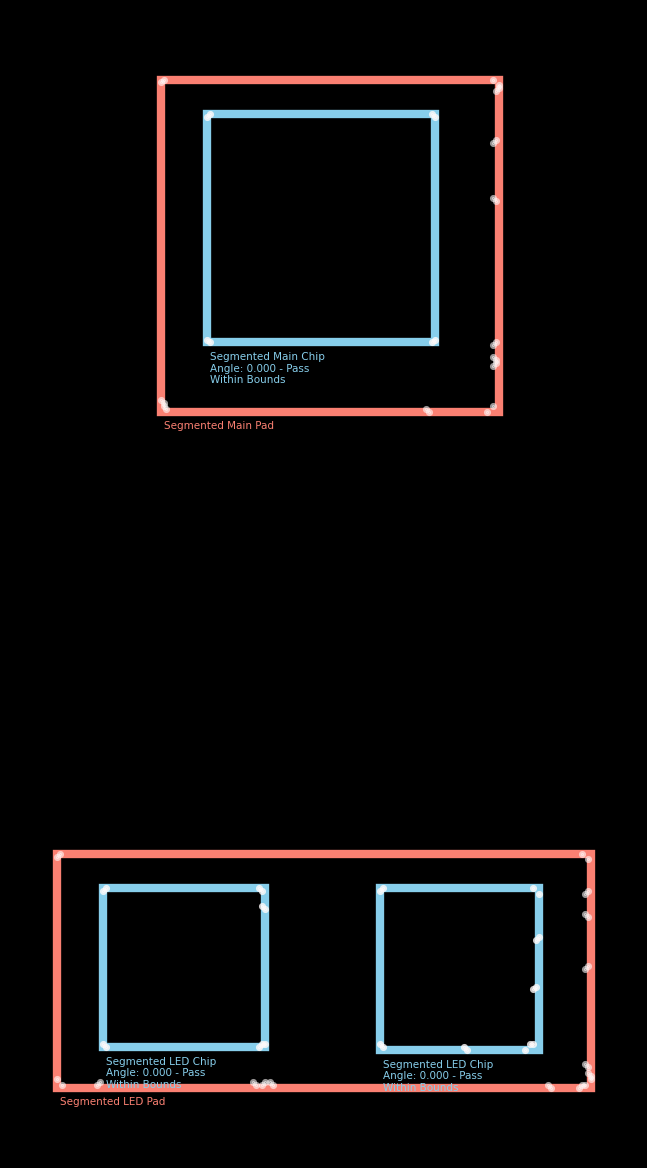

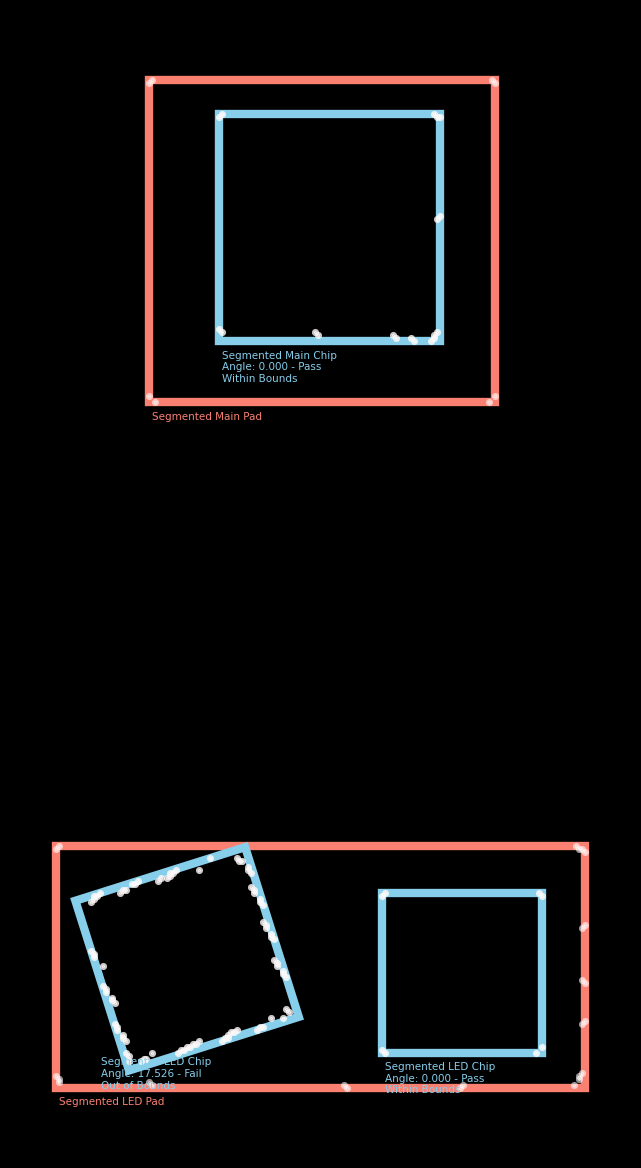

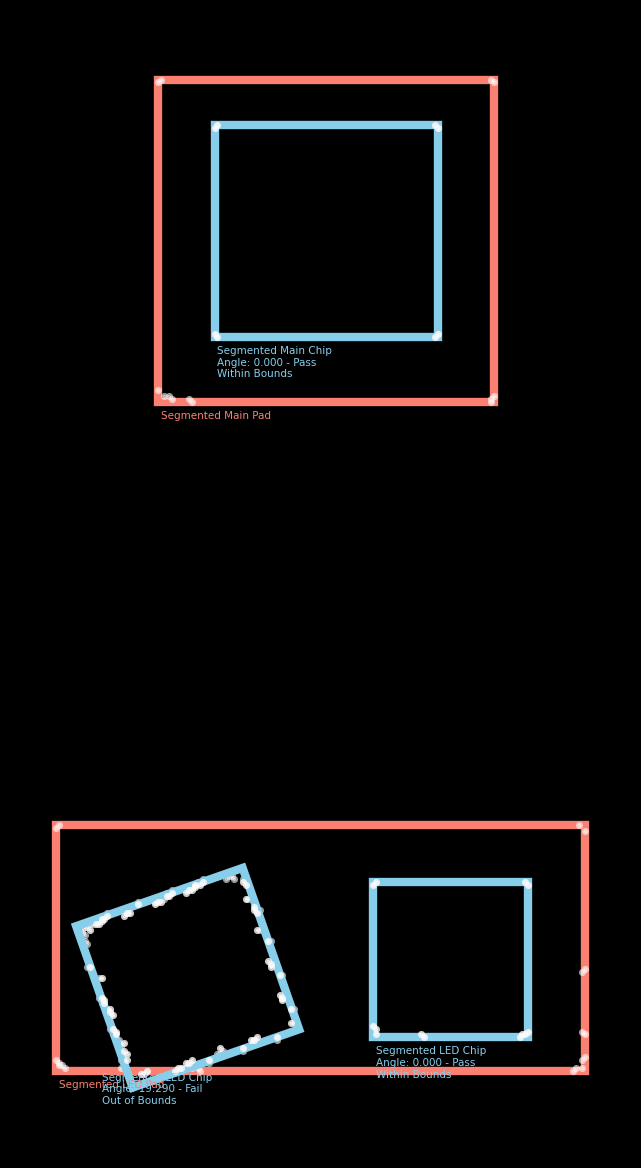

In [176]:
lbl_color = {
    0: {
        "box": ["salmon", 1],
        "seg": ["snow", 0.6],
        "pred": ["gold", 1],
        "text": "salmon"
    },
    1: {
        "box": ["salmon", 1],
        "seg": ["snow", 0.6],
        "pred": ["gold", 1],
        "text": "salmon"
    },
    2: {
        "box": ["skyblue", 1],
        "seg": ["snow", 0.8],
        "text": "skyblue"
    },
    3: {
        "box": ["skyblue", 1],
        "seg": ["snow", 0.8],
        "text": "skyblue"
    }
}

log_level = 0

plot_data(results, color=lbl_color, 
          label_lvl=2, 
          predict=False, 
          plot_seg=True,
          led_only=False)

